In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [2]:
''' The following shows the result of training various non-nerual network models on a cleaned version of the 
Kannada set transliterated so that all comments are in the Kannada script. models are trained on an tf-idf vectorizer
with dimensionality reduction.'''

' The following shows the result of training various non-nerual network models on a cleaned version of the \nKannada set transliterated so that all comments are in the Kannada script. models are trained on an tf-idf vectorizer\nwith dimensionality reduction.'

In [3]:
# import data
kan_train = pd.read_table("../datasets/task_a/kan_sentiment_train.tsv")
kan_dev = pd.read_table("../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


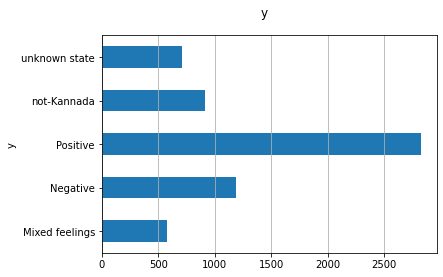

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
# read in the list of stopwords in Kannada
with open('stopwords-kn.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

lst_stopwords = lines

In [8]:
# transliterate all data from english scrip to kannada script
from indictrans import Transliterator

# instantiate the trasnliteration
trn = Transliterator(source='eng', target='kan', build_lookup=True)

# save the text column as a list in order to improve performance.
orig_kn_train = (kan_train['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans = []
for i in range(len(orig_kn_train)):
    list_trans.append(trn.transform(orig_kn_train[i]))
    
# append the transliterated texts as a column on original dataframe
kan_train['text_trans'] = list_trans

In [9]:
kan_train_trans = kan_train.drop(['text'], axis=1)
kan_train_trans.rename(columns={'text_trans':'text'}, inplace= True)
kan_train_trans

,y,text
0,Negative,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...
1,Positive,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...
2,not-Kannada,ಸುಪರ್ ಸಾರ ಸೋಂಗ್
3,Negative,ಟೀಕ್ಟೋಕರ್ಸ್ ಪ್ರಸೇಂಟ್ ಸಿತುಂಏಶನ್... ನನೋಡುವವರು ಯಾ...
4,Positive,ಸುಪರ್ ಸಾಂಗ್ ವೆರಿ ನೈಸ್....
...,...,...
6207,not-Kannada,@ಆ.ರ.ವ್ ಟುಂಬಾದ್ ತನ್ಹಾಜಿ ಅಂಧಾಧುನ ಐಸೆ ಬಹೋತ ಹೈ ...
6208,not-Kannada,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്
6209,Negative,ಬ್ರೊ...ನ್ನೀನ್ ಎಸ್ಟೆ ರೋಸ್ತ ಮದುದ್ರು...ಚೀನಾ ನೇ ಬೇ...
6210,Positive,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...


In [10]:
# do the same for the dev data
# save the text column as a list in order to improve performance.
orig_kn_dev = (kan_dev['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans_dev = []
for i in range(len(orig_kn_dev)):
    list_trans_dev.append(trn.transform(orig_kn_dev[i]))
    
# append the transliterated texts as a column on original dataframe
kan_dev['text_trans'] = list_trans_dev

In [11]:
kan_dev_trans = kan_dev.drop(['text'], axis=1)
kan_dev_trans.rename(columns={'text_trans':'text'}, inplace= True)
kan_dev_trans

,y,text
0,Mixed feelings,ಬಿಂದೂಗೇ ಸರ್ಯಗೀ ಉಗೀಥೀದೀರಾ ಗುಡ್ ಗೋ ಅಹೆಡ್ ವೇ ಅರೇ...
1,Positive,ಯೇನ ಸೋಂಗ್ ಗುರು ...ಸುಪರ್
2,not-Kannada,ಮೀ ಫೆವರತ ಸ್ಟೋರಿ
3,Positive,ಸುಪರ್ ತೋಗರಿ ತೀಪ್ಪ
4,Positive,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...
...,...,...
686,Negative,@ನಂದೀ ಪಾರ್ಥಾಸರಥೀ ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ
687,Negative,ಹುಗೀ ಗುರು ಬದೇತಾಕೆ
688,Positive,ಟ್ರೆಂಡಿಂಗ್ ನೋ.1 ವೋ
689,Positive,@ಟ್ರೋಲ್ ಸ್ತುಪಿಡ್ ಫಂಸ ನಾನು ಆದಿಕಏ ಕಾನೋ ಹೇಲ್ಥೀರೋದ...


In [12]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned text
'''
def utils_preprocess_text(text, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
#Now we can apply the preprocessing function to our data

kan_train_trans["text_clean"] = kan_train_trans["text"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

kan_dev_trans["text_clean"] = kan_dev_trans["text"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

In [14]:
kan_dev_trans

,y,text,text_clean
0,Mixed feelings,ಬಿಂದೂಗೇ ಸರ್ಯಗೀ ಉಗೀಥೀದೀರಾ ಗುಡ್ ಗೋ ಅಹೆಡ್ ವೇ ಅರೇ...,ಬದಗ ಸರಯಗ ಉಗಥದರ ಗಡ ಗ ಅಹಡ ವ ಅರ ಎಜಇಗ ವಲ
1,Positive,ಯೇನ ಸೋಂಗ್ ಗುರು ...ಸುಪರ್,ಯನ ಸಗ ಗರ ಸಪರ
2,not-Kannada,ಮೀ ಫೆವರತ ಸ್ಟೋರಿ,ಮ ಫವರತ ಸಟರ
3,Positive,ಸುಪರ್ ತೋಗರಿ ತೀಪ್ಪ,ಸಪರ ತಗರ ತಪಪ
4,Positive,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,ನಮಮ ಮತಗಳ ಅಕಷರಶ ಸತಯ ನಮಮ ಸಮನಯ ಜವನ ನಡ ಕಷ ಆಯತ
...,...,...,...
686,Negative,@ನಂದೀ ಪಾರ್ಥಾಸರಥೀ ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,ನದ ಪರಥಸರಥ ನಮಮ ಅಪಪ ದಡ ಗಡ ಸಳಮಗ
687,Negative,ಹುಗೀ ಗುರು ಬದೇತಾಕೆ,ಹಗ ಗರ ಬದತಕ
688,Positive,ಟ್ರೆಂಡಿಂಗ್ ನೋ.1 ವೋ,ಟರಡಗ ನ1 ವ
689,Positive,@ಟ್ರೋಲ್ ಸ್ತುಪಿಡ್ ಫಂಸ ನಾನು ಆದಿಕಏ ಕಾನೋ ಹೇಲ್ಥೀರೋದ...,ಟರಲ ಸತಪಡ ಫಸ ನನ ಆದಕಏ ಕನ ಹಲಥರದ ನನನತ ಜಥ ನಯ ಹಥಡಕ ಪ...


In [15]:
# Now we can define our training data and our dev data as well as targets
train = kan_train_trans
test = kan_dev_trans

y_train = kan_train_trans['y'].values
y_test = kan_dev_trans['y'].values


## Using Tf-Idf vectorizer

In [16]:
## Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [17]:
# now run thse vectorizers on the train data
corpus = train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [18]:
X_train

<6212x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49645 stored elements in Compressed Sparse Row format>

Text(0.5, 1.0, 'Sparse Matrix Sample')

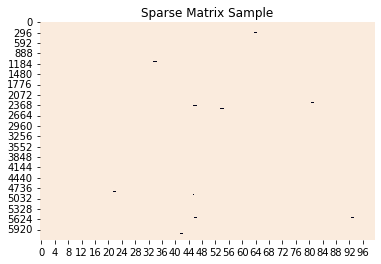

In [19]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## reducing the vectorizers dimensionality

In [20]:
# reduce dimensionality through feature selection

y = y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [21]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Mixed feelings:
  . selected features: 315
  . top features: ಗಮ,ಯವ ಗಮ,ಗಮ ಯವಡ,ಗಮ ನಮ,ಬರ ಗಮ,ಗಮ ಯವದ,ಸಪರ,ಯವಡ ಬರ,32,ಕಮಯನಸಟ
 
# Negative:
  . selected features: 352
  . top features: ಸಪರ,ನನ,ನದ ಪರಥಸರಥ,ಪರಥಸರಥ,ಡಸಲಕ,ಶತ,ಗದ,ನದ,ಯಕ,ರಶಮಕ
 
# Positive:
  . selected features: 135
  . top features: ಚರತರ,ನವ,ಇದ ಚರತರ,ತಪಪ,ಶಟಟ,ಇದ,ಟರಲ ವಡಯ,ಗಯರಟ,ಚದನ ಶಟಟ,ನಗಡಡ
 
# not-Kannada:
  . selected features: 246
  . top features: ಸಪರ,ಸಪರ ಬರ,ಸಪರ ಸಗ,ಅಜಲ ದವ,ಅಜಲ,ದವ,ಬರ,ಸಗ,ಗಡ,ನಸ
 
# unknown state:
  . selected features: 231
  . top features: ಯಸ,ಗತ ಬರ,ಪರಮವಹ,ಪರಮವಹ ಮಯಸಕ,ಜಈನ,ಲಕ,ಕರತಕ,ಗದಯಗ,ಸಪರ,ಆಶ
 


## re-fitting the vectorizer on the new vocabulary gained through feature reduction

In [22]:
# we can now refit the vecotrizer on the corpus by giving this new set of words as input.
# producing a smaller feature matrix and a shorter vocabulary.
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


In [23]:
X_train.shape

(6212, 1170)

Text(0.5, 1.0, 'Sparse Matrix Sample')

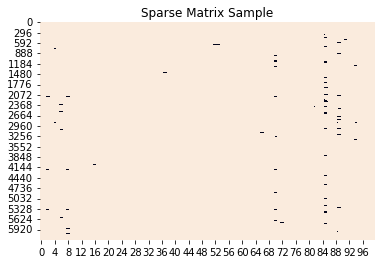

In [24]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# Training a Naive Bayes Classifier

In [25]:
# Now we can train a model. i'm using a naive bayes classifier
classifier = naive_bayes.MultinomialNB()

In [26]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.56
Auc: 0.8
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.00      0.00      0.00        52
      Negative       0.63      0.53      0.58       139
      Positive       0.55      0.92      0.69       321
   not-Kannada       0.78      0.16      0.27       110
 unknown state       0.33      0.04      0.08        69

      accuracy                           0.56       691
     macro avg       0.46      0.33      0.32       691
  weighted avg       0.54      0.56      0.48       691



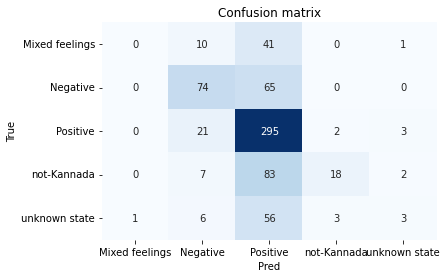

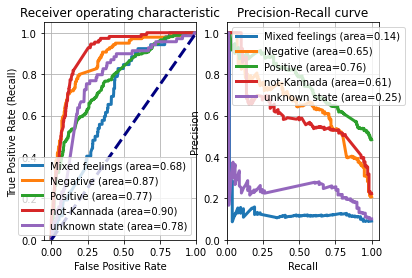

In [27]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()


In [28]:
#expolainer

## select observation
i = 1
txt_instance = test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Positive --> Pred: Positive | Prob: 0.86


/home/ubuntu/pyenv/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Training a cat boost classifier

In [29]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(
    iterations=1000, 
    learning_rate=1.2, 
    #loss_function='CrossEntropy'
)


In [30]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.4140707	total: 84.8ms	remaining: 1m 24s
1:	learn: 1.3537152	total: 113ms	remaining: 56.2s
2:	learn: 1.3174025	total: 140ms	remaining: 46.5s
3:	learn: 1.2964535	total: 167ms	remaining: 41.6s
4:	learn: 1.2676290	total: 195ms	remaining: 38.8s
5:	learn: 1.2461290	total: 222ms	remaining: 36.8s
6:	learn: 1.2249908	total: 249ms	remaining: 35.4s
7:	learn: 1.2084732	total: 276ms	remaining: 34.2s
8:	learn: 1.1935916	total: 304ms	remaining: 33.5s
9:	learn: 1.1827312	total: 330ms	remaining: 32.7s
10:	learn: 1.1665258	total: 357ms	remaining: 32.1s
11:	learn: 1.1576638	total: 384ms	remaining: 31.7s
12:	learn: 1.1510616	total: 411ms	remaining: 31.2s
13:	learn: 1.1420742	total: 439ms	remaining: 30.9s
14:	learn: 1.1336535	total: 466ms	remaining: 30.6s
15:	learn: 1.1253625	total: 493ms	remaining: 30.3s
16:	learn: 1.1189594	total: 520ms	remaining: 30.1s
17:	learn: 1.1146020	total: 547ms	remaining: 29.8s
18:	learn: 1.1099317	total: 573ms	remaining: 29.6s
19:	learn: 1.1050822	total: 600ms	remai

168:	learn: 0.8517941	total: 4.62s	remaining: 22.7s
169:	learn: 0.8513503	total: 4.65s	remaining: 22.7s
170:	learn: 0.8502801	total: 4.67s	remaining: 22.7s
171:	learn: 0.8494187	total: 4.7s	remaining: 22.6s
172:	learn: 0.8486385	total: 4.73s	remaining: 22.6s
173:	learn: 0.8478241	total: 4.75s	remaining: 22.6s
174:	learn: 0.8470555	total: 4.78s	remaining: 22.5s
175:	learn: 0.8460088	total: 4.81s	remaining: 22.5s
176:	learn: 0.8451954	total: 4.84s	remaining: 22.5s
177:	learn: 0.8439784	total: 4.86s	remaining: 22.5s
178:	learn: 0.8434611	total: 4.89s	remaining: 22.4s
179:	learn: 0.8429646	total: 4.92s	remaining: 22.4s
180:	learn: 0.8411859	total: 4.95s	remaining: 22.4s
181:	learn: 0.8393439	total: 4.97s	remaining: 22.3s
182:	learn: 0.8390814	total: 5s	remaining: 22.3s
183:	learn: 0.8384039	total: 5.03s	remaining: 22.3s
184:	learn: 0.8376197	total: 5.05s	remaining: 22.3s
185:	learn: 0.8371418	total: 5.08s	remaining: 22.2s
186:	learn: 0.8368080	total: 5.11s	remaining: 22.2s
187:	learn: 0.83

328:	learn: 0.7565341	total: 8.95s	remaining: 18.3s
329:	learn: 0.7557084	total: 8.98s	remaining: 18.2s
330:	learn: 0.7551250	total: 9.01s	remaining: 18.2s
331:	learn: 0.7540520	total: 9.03s	remaining: 18.2s
332:	learn: 0.7537105	total: 9.06s	remaining: 18.1s
333:	learn: 0.7533191	total: 9.09s	remaining: 18.1s
334:	learn: 0.7530073	total: 9.11s	remaining: 18.1s
335:	learn: 0.7528793	total: 9.14s	remaining: 18.1s
336:	learn: 0.7523999	total: 9.17s	remaining: 18s
337:	learn: 0.7520433	total: 9.19s	remaining: 18s
338:	learn: 0.7516191	total: 9.22s	remaining: 18s
339:	learn: 0.7511234	total: 9.25s	remaining: 18s
340:	learn: 0.7506951	total: 9.27s	remaining: 17.9s
341:	learn: 0.7503469	total: 9.3s	remaining: 17.9s
342:	learn: 0.7498655	total: 9.33s	remaining: 17.9s
343:	learn: 0.7494964	total: 9.36s	remaining: 17.8s
344:	learn: 0.7492451	total: 9.38s	remaining: 17.8s
345:	learn: 0.7487251	total: 9.41s	remaining: 17.8s
346:	learn: 0.7483976	total: 9.44s	remaining: 17.8s
347:	learn: 0.7475593

488:	learn: 0.6961101	total: 13.3s	remaining: 13.9s
489:	learn: 0.6955783	total: 13.3s	remaining: 13.8s
490:	learn: 0.6953074	total: 13.3s	remaining: 13.8s
491:	learn: 0.6950929	total: 13.4s	remaining: 13.8s
492:	learn: 0.6947202	total: 13.4s	remaining: 13.8s
493:	learn: 0.6944721	total: 13.4s	remaining: 13.7s
494:	learn: 0.6933142	total: 13.4s	remaining: 13.7s
495:	learn: 0.6928759	total: 13.5s	remaining: 13.7s
496:	learn: 0.6923448	total: 13.5s	remaining: 13.7s
497:	learn: 0.6916274	total: 13.5s	remaining: 13.6s
498:	learn: 0.6913801	total: 13.6s	remaining: 13.6s
499:	learn: 0.6911341	total: 13.6s	remaining: 13.6s
500:	learn: 0.6909734	total: 13.6s	remaining: 13.5s
501:	learn: 0.6908410	total: 13.6s	remaining: 13.5s
502:	learn: 0.6906605	total: 13.7s	remaining: 13.5s
503:	learn: 0.6905346	total: 13.7s	remaining: 13.5s
504:	learn: 0.6901081	total: 13.7s	remaining: 13.4s
505:	learn: 0.6898669	total: 13.7s	remaining: 13.4s
506:	learn: 0.6897103	total: 13.8s	remaining: 13.4s
507:	learn: 

648:	learn: 0.6515298	total: 17.7s	remaining: 9.55s
649:	learn: 0.6513854	total: 17.7s	remaining: 9.53s
650:	learn: 0.6512115	total: 17.7s	remaining: 9.5s
651:	learn: 0.6510002	total: 17.7s	remaining: 9.47s
652:	learn: 0.6506100	total: 17.8s	remaining: 9.44s
653:	learn: 0.6500429	total: 17.8s	remaining: 9.42s
654:	learn: 0.6499103	total: 17.8s	remaining: 9.39s
655:	learn: 0.6498159	total: 17.9s	remaining: 9.36s
656:	learn: 0.6497347	total: 17.9s	remaining: 9.33s
657:	learn: 0.6496045	total: 17.9s	remaining: 9.31s
658:	learn: 0.6494576	total: 17.9s	remaining: 9.28s
659:	learn: 0.6491509	total: 18s	remaining: 9.25s
660:	learn: 0.6484976	total: 18s	remaining: 9.22s
661:	learn: 0.6482339	total: 18s	remaining: 9.2s
662:	learn: 0.6478665	total: 18s	remaining: 9.17s
663:	learn: 0.6474716	total: 18.1s	remaining: 9.14s
664:	learn: 0.6470603	total: 18.1s	remaining: 9.12s
665:	learn: 0.6468083	total: 18.1s	remaining: 9.09s
666:	learn: 0.6462803	total: 18.2s	remaining: 9.06s
667:	learn: 0.6457754	

811:	learn: 0.6181882	total: 22.2s	remaining: 5.14s
812:	learn: 0.6181030	total: 22.2s	remaining: 5.11s
813:	learn: 0.6178784	total: 22.2s	remaining: 5.08s
814:	learn: 0.6177536	total: 22.3s	remaining: 5.06s
815:	learn: 0.6176554	total: 22.3s	remaining: 5.03s
816:	learn: 0.6174118	total: 22.3s	remaining: 5s
817:	learn: 0.6171666	total: 22.4s	remaining: 4.97s
818:	learn: 0.6171031	total: 22.4s	remaining: 4.95s
819:	learn: 0.6170261	total: 22.4s	remaining: 4.92s
820:	learn: 0.6167922	total: 22.4s	remaining: 4.89s
821:	learn: 0.6166293	total: 22.5s	remaining: 4.87s
822:	learn: 0.6162520	total: 22.5s	remaining: 4.84s
823:	learn: 0.6161080	total: 22.5s	remaining: 4.81s
824:	learn: 0.6159825	total: 22.5s	remaining: 4.78s
825:	learn: 0.6159336	total: 22.6s	remaining: 4.75s
826:	learn: 0.6157568	total: 22.6s	remaining: 4.73s
827:	learn: 0.6156476	total: 22.6s	remaining: 4.7s
828:	learn: 0.6155803	total: 22.7s	remaining: 4.67s
829:	learn: 0.6154391	total: 22.7s	remaining: 4.65s
830:	learn: 0.61

971:	learn: 0.5968534	total: 26.5s	remaining: 764ms
972:	learn: 0.5967546	total: 26.6s	remaining: 737ms
973:	learn: 0.5965795	total: 26.6s	remaining: 710ms
974:	learn: 0.5965245	total: 26.6s	remaining: 682ms
975:	learn: 0.5963977	total: 26.6s	remaining: 655ms
976:	learn: 0.5963443	total: 26.7s	remaining: 628ms
977:	learn: 0.5960976	total: 26.7s	remaining: 600ms
978:	learn: 0.5959653	total: 26.7s	remaining: 573ms
979:	learn: 0.5958968	total: 26.7s	remaining: 546ms
980:	learn: 0.5958298	total: 26.8s	remaining: 519ms
981:	learn: 0.5958161	total: 26.8s	remaining: 491ms
982:	learn: 0.5957745	total: 26.8s	remaining: 464ms
983:	learn: 0.5956377	total: 26.9s	remaining: 437ms
984:	learn: 0.5955154	total: 26.9s	remaining: 409ms
985:	learn: 0.5954997	total: 26.9s	remaining: 382ms
986:	learn: 0.5953846	total: 26.9s	remaining: 355ms
987:	learn: 0.5952944	total: 27s	remaining: 327ms
988:	learn: 0.5952489	total: 27s	remaining: 300ms
989:	learn: 0.5951465	total: 27s	remaining: 273ms
990:	learn: 0.5951

Accuracy: 0.57
Auc: 0.79
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.25      0.08      0.12        52
      Negative       0.56      0.56      0.56       139
      Positive       0.60      0.76      0.67       321
   not-Kannada       0.62      0.48      0.54       110
 unknown state       0.29      0.17      0.22        69

      accuracy                           0.57       691
     macro avg       0.46      0.41      0.42       691
  weighted avg       0.54      0.57      0.54       691



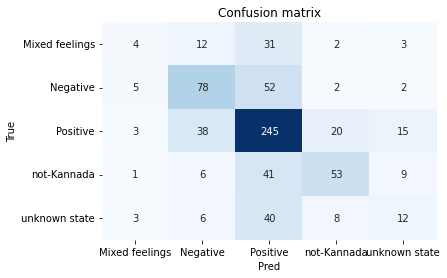

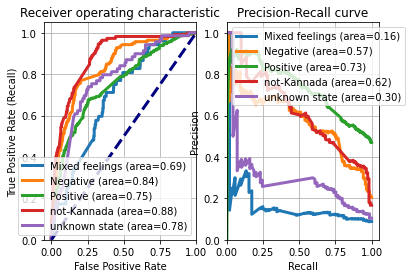

In [31]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=150, n_estimators=30, max_features=1000)

In [33]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.56
Auc: 0.78
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.30      0.06      0.10        52
      Negative       0.58      0.61      0.59       139
      Positive       0.59      0.76      0.66       321
   not-Kannada       0.57      0.42      0.48       110
 unknown state       0.25      0.14      0.18        69

      accuracy                           0.56       691
     macro avg       0.46      0.40      0.40       691
  weighted avg       0.53      0.56      0.53       691



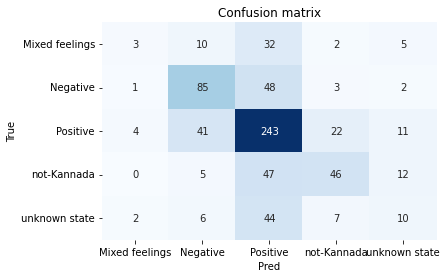

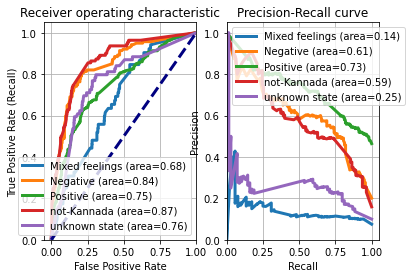

In [34]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [35]:
from sklearn.linear_model import LogisticRegression
classifier =LogisticRegression(random_state=0, max_iter= 100)

In [36]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.58
Auc: 0.81
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.25      0.04      0.07        52
      Negative       0.62      0.66      0.64       139
      Positive       0.59      0.83      0.69       321
   not-Kannada       0.59      0.33      0.42       110
 unknown state       0.24      0.07      0.11        69

      accuracy                           0.58       691
     macro avg       0.46      0.39      0.39       691
  weighted avg       0.54      0.58      0.53       691



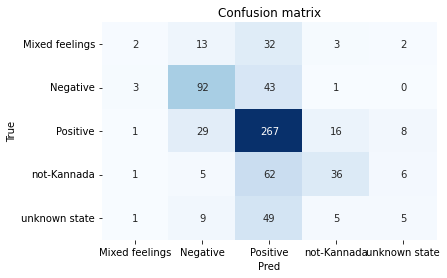

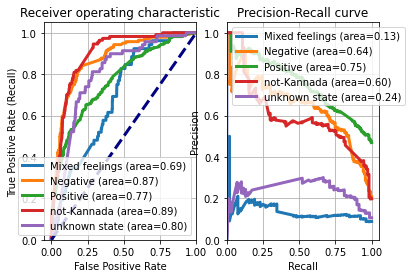

In [37]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=10, weights='distance')

In [39]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.53
Auc: 0.73
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.30      0.12      0.17        52
      Negative       0.65      0.42      0.51       139
      Positive       0.56      0.77      0.65       321
   not-Kannada       0.55      0.40      0.46       110
 unknown state       0.21      0.17      0.19        69

      accuracy                           0.53       691
     macro avg       0.45      0.38      0.40       691
  weighted avg       0.52      0.53      0.51       691



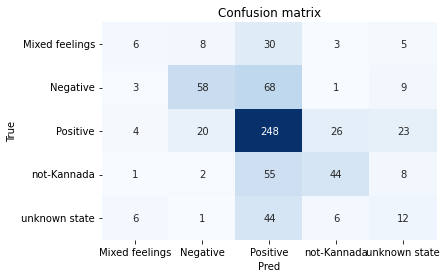

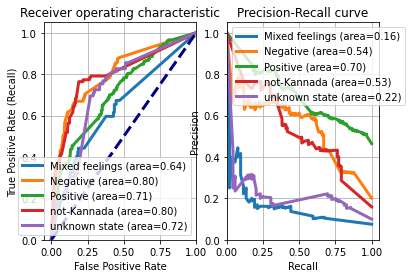

In [40]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()